In [1]:
import pandas as pd
import random
import os
import numpy as np

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, random
warnings.filterwarnings(action='ignore')

from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from category_encoders.ordinal import OrdinalEncoder
from sklearn.model_selection import StratifiedKFold

from sklearn.cluster import KMeans
from catboost import CatBoostClassifier, Pool, CatBoostRegressor
from sklearn.model_selection import train_test_split

import catboost as cb
import optuna
from sklearn.metrics import accuracy_score
from optuna.samplers import TPESampler

from teddynote import models

In [2]:
class CFG:
    SEED = 42

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(CFG.SEED) # Seed 고정

In [4]:
train = pd.read_csv('open/train.csv')
test = pd.read_csv('open/test.csv')

In [5]:
def get_x_y(df):
    if 'class' in df.columns:
        df_x = df.drop(columns=['id', 'class','father','mother','gender'])
        df_y = df['class']
        return df_x, df_y
    else:
        df_x = df.drop(columns=['id','father','mother','gender'])
        return df_x

train_x, train_y = get_x_y(train)
test_x = get_x_y(test)
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,2,G G,A G,A A,G A,C A,A A,A A,G G,A A,G G,A G,A A,A A,A A,A A
1,2,A G,A G,C A,A A,A A,A G,A A,G A,A A,A G,A A,G A,G G,A A,A A
2,2,G G,G G,A A,G A,C C,G G,A A,G A,G A,A G,A A,A A,A A,A A,A A
3,1,A A,G G,A A,G A,A A,G G,G G,A A,G G,A G,G G,G G,G G,A A,G G
4,2,G G,G G,C C,A A,C C,A A,A A,A A,A A,G G,A A,A A,A G,A A,G A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,A G,A G,A A,G A,C C,A G,A A,G A,A A,G G,A G,G A,A A,A A,A A
258,2,G G,A A,C A,A A,A A,A G,G A,G A,A A,A G,A G,A A,A G,A A,G A
259,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A A,G G,G G,G G,C A,G G
260,1,A A,G G,A A,G A,A A,G G,G G,A A,G A,A G,A G,G A,G G,C A,G G


In [6]:
test_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,1,A G,G G,A A,G A,A A,A G,G G,G A,G A,A G,A G,G A,G G,C A,G A
1,2,G G,A G,C C,G G,C C,A A,A A,A A,A A,G G,A G,A A,A A,A A,A A
2,2,G G,A G,A A,A A,C A,A G,A A,A A,A A,A G,A A,G A,G G,A A,G G
3,2,G G,A G,C A,A A,C C,A A,A A,A A,A A,G G,A A,G A,A G,A A,A A
4,1,A A,G G,A A,G G,A A,G G,G G,A A,G G,A G,G G,G A,G G,A A,G G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
170,2,A G,G G,C C,A A,C A,A G,A A,G G,A A,G G,G G,A A,A A,A A,G A
171,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,A G,A A,A A,A G,A A,G A
172,2,G G,A A,A A,A A,C A,A G,A A,A A,A A,G G,A G,A A,A G,A A,G G
173,2,A G,G G,C A,G A,C C,G G,A A,G A,A A,G G,A G,A A,A A,A A,A A


In [7]:
train_y

0      B
1      C
2      B
3      A
4      C
      ..
257    B
258    C
259    A
260    A
261    B
Name: class, Length: 262, dtype: object

In [8]:
class_le = preprocessing.LabelEncoder()
snp_le = preprocessing.LabelEncoder()
snp_col = [f'SNP_{str(x).zfill(2)}' for x in range(1,16)]

snp_data = []
for col in snp_col:
    snp_data += list(train_x[col].values)

train_y = class_le.fit_transform(train_y)
snp_le.fit(snp_data)

LabelEncoder()

In [9]:
for col in train_x.columns:
    if col in snp_col:
        train_x[col] = snp_le.transform(train_x[col])
        test_x[col] = snp_le.transform(test_x[col])

In [10]:
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15
0,2,5,1,0,4,2,0,0,5,0,5,1,0,0,0,0
1,2,1,1,2,0,0,1,0,4,0,1,0,4,5,0,0
2,2,5,5,0,4,3,5,0,4,4,1,0,0,0,0,0
3,1,0,5,0,4,0,5,5,0,5,1,5,5,5,0,5
4,2,5,5,3,0,3,0,0,0,0,5,0,0,1,0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,1,1,0,4,3,1,0,4,0,5,1,4,0,0,0
258,2,5,0,2,0,0,1,4,4,0,1,1,0,1,0,4
259,1,1,5,0,4,0,1,5,4,4,0,5,5,5,2,5
260,1,0,5,0,4,0,5,5,0,4,1,1,4,5,2,5


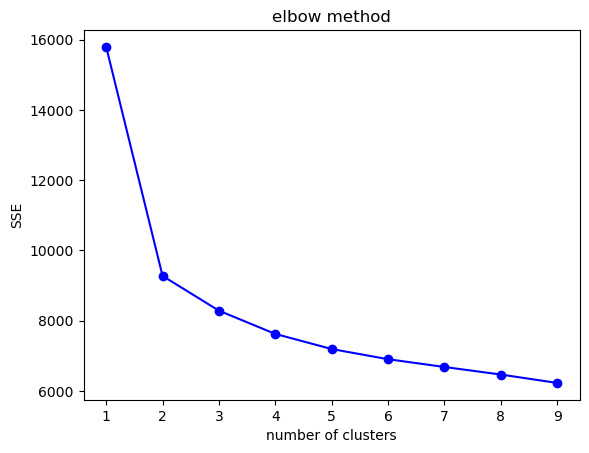

In [11]:
def elbow(data, length):
    sse = [] # sum of squre error 오차제곱합
    for i in range(1, length):
        kmeans = KMeans(n_clusters=i)
        kmeans.fit(data)
        # SSE 값 저장
        sse.append(kmeans.inertia_)
    plt.plot(range(1, length), sse, 'bo-')
    plt.title("elbow method")
    plt.xlabel("number of clusters")
    plt.ylabel("SSE")
    plt.show()
elbow(train_x, 10)

In [12]:
kmeans_train = train_x
kmeans = KMeans(n_clusters=3, random_state=42).fit(kmeans_train)
train_x['cluster'] = kmeans.predict(kmeans_train)
test_x['cluster'] = kmeans.predict(test_x)

In [13]:
train_x

,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,cluster
0,2,5,1,0,4,2,0,0,5,0,5,1,0,0,0,0,2
1,2,1,1,2,0,0,1,0,4,0,1,0,4,5,0,0,0
2,2,5,5,0,4,3,5,0,4,4,1,0,0,0,0,0,2
3,1,0,5,0,4,0,5,5,0,5,1,5,5,5,0,5,1
4,2,5,5,3,0,3,0,0,0,0,5,0,0,1,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
257,2,1,1,0,4,3,1,0,4,0,5,1,4,0,0,0,2
258,2,5,0,2,0,0,1,4,4,0,1,1,0,1,0,4,0
259,1,1,5,0,4,0,1,5,4,4,0,5,5,5,2,5,1
260,1,0,5,0,4,0,5,5,0,4,1,1,4,5,2,5,1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.2)

In [15]:
X_train


,trait,SNP_01,SNP_02,SNP_03,SNP_04,SNP_05,SNP_06,SNP_07,SNP_08,SNP_09,SNP_10,SNP_11,SNP_12,SNP_13,SNP_14,SNP_15,cluster
16,1,0,5,0,5,0,5,5,0,4,5,1,5,5,2,5,1
236,2,1,1,3,4,2,1,0,5,4,5,1,0,5,0,0,2
70,2,1,0,2,0,2,1,0,4,0,1,0,0,5,0,0,0
29,1,1,5,0,4,0,5,5,0,4,0,5,5,5,0,5,1
132,2,5,5,3,4,2,5,0,5,0,5,5,0,5,0,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,2,5,5,0,4,3,5,0,4,4,1,0,0,0,0,0,2
21,2,5,1,3,0,3,1,0,5,0,5,5,0,1,0,4,2
207,2,5,1,2,5,2,5,0,4,4,5,1,0,1,0,0,2
83,1,1,5,0,4,0,5,5,0,4,0,5,5,5,3,5,1


In [16]:
seed = 42
n_fold = 7   #FOLD 10
n_class = 3
X = train_x
y = train_y
X_test = X_test

In [17]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X_train, y_train):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['trait','SNP_01','SNP_02','SNP_03','SNP_04','SNP_05','SNP_06','SNP_07','SNP_08','SNP_09','SNP_10','SNP_11','SNP_12','SNP_13','SNP_14','SNP_15']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat = CatBoostClassifier(n_estimators= 1500, eta =0.03, max_depth = 7) # n_estimators= 1500, eta =0.02, max_depth = 6
  model_cat.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=100, verbose=100)
  

  #cat_pred[valid_idx] = model_cat.predict_proba(X_valid)
  #cat_pred_test += model_cat.predict_proba(X_test) / n_fold
  #print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')


----------------- Fold 0 -----------------

0:	learn: 1.0726675	test: 1.0749602	best: 1.0749602 (0)	total: 337ms	remaining: 8m 25s
100:	learn: 0.3081561	test: 0.4186331	best: 0.4186331 (100)	total: 15.8s	remaining: 3m 38s
200:	learn: 0.1752344	test: 0.2955006	best: 0.2955006 (200)	total: 35.1s	remaining: 3m 46s
300:	learn: 0.1181436	test: 0.2456153	best: 0.2454775 (299)	total: 1m 5s	remaining: 4m 19s
400:	learn: 0.0869081	test: 0.2239302	best: 0.2239302 (400)	total: 1m 26s	remaining: 3m 57s
500:	learn: 0.0677993	test: 0.2074995	best: 0.2074995 (500)	total: 1m 49s	remaining: 3m 37s
600:	learn: 0.0550937	test: 0.1993546	best: 0.1993546 (600)	total: 2m 14s	remaining: 3m 21s
700:	learn: 0.0462145	test: 0.1926537	best: 0.1925757 (699)	total: 2m 34s	remaining: 2m 55s
800:	learn: 0.0395542	test: 0.1870396	best: 0.1870020 (799)	total: 2m 54s	remaining: 2m 32s
900:	learn: 0.0344789	test: 0.1826223	best: 0.1826223 (900)	total: 3m 15s	remaining: 2m 10s
1000:	learn: 0.0305304	test: 0.1766392	best

KeyboardInterrupt: 

In [ ]:
preds = model_cat.predict(X_test)
print('Done.')

In [ ]:
from sklearn.metrics import accuracy_score as acc
acc(y_test, preds)

In [ ]:
preds = model_cat.predict(train_x)
print('Done.')
acc(train_y, preds)

In [ ]:
train_y

In [ ]:
preds = model_cat.predict(test_x)
print('Done.')
print(preds)



In [ ]:
def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

In [ ]:
plot_feature_importance(model_cat.get_feature_importance(),X_test.columns,'CATBOOST')

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

submit['class'] = class_le.inverse_transform(preds)

submit.to_csv('./answer/catfin10.csv', index=False)

In [ ]:
n_fold=5

In [ ]:
skfold = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)
folds=[]
for train_idx, valid_idx in skfold.split(X, y):
        folds.append((train_idx, valid_idx))

cat_pred = np.zeros((X.shape[0], n_class))
cat_pred_test = np.zeros((X_test.shape[0], n_class))
cat_cols = ['trait','SNP_01','SNP_02','SNP_03','SNP_04','SNP_05','SNP_06','SNP_07','SNP_08','SNP_09','SNP_10','SNP_11','SNP_12','SNP_13','SNP_14','SNP_15']
for fold in range(n_fold):
  print(f'\n----------------- Fold {fold} -----------------\n')
  train_idx, valid_idx = folds[fold]
  X_train, X_valid, y_train, y_valid = X.iloc[train_idx], X.iloc[valid_idx], y[train_idx], y[valid_idx]
  train_data = Pool(data=X_train, label=y_train, cat_features=cat_cols)
  valid_data = Pool(data=X_valid, label=y_valid, cat_features=cat_cols)

  model_cat2 = CatBoostClassifier()
  model_cat2.fit(train_data, eval_set=valid_data, use_best_model=True, early_stopping_rounds=150, verbose=100)
  
  cat_pred[valid_idx] = model_cat2.predict_proba(X_valid)
  cat_pred_test += model_cat2.predict_proba(X_test) / n_fold
  print(f'CV Log Loss Score: {log_loss(y_valid, cat_pred[valid_idx]):.6f}')
    
print(f'\tLog Loss: {log_loss(y, cat_pred):.6f}')


In [ ]:
preds2 = model_cat2.predict(X_test)
print('Done.')

In [ ]:
from sklearn.metrics import accuracy_score as acc
acc(y_test, preds2)

In [ ]:
preds2 = model_cat2.predict(test_x)
print('Done.')
print(preds2)



In [ ]:
acc(preds2, preds)